<a href="https://colab.research.google.com/github/Sompote/peak_velocity/blob/main/peak_velosity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cuda
Epoch 20, Train Loss: 0.6250, Val Loss: 1.0067
Epoch 40, Train Loss: 0.4991, Val Loss: 0.7133
Epoch 60, Train Loss: 0.4264, Val Loss: 0.5187
Epoch 80, Train Loss: 0.3996, Val Loss: 0.4483
Epoch 100, Train Loss: 0.4282, Val Loss: 0.3878
Epoch 120, Train Loss: 0.3706, Val Loss: 0.3162
Epoch 140, Train Loss: 0.2841, Val Loss: 0.3166
Epoch 160, Train Loss: 0.2405, Val Loss: 0.2196
Epoch 180, Train Loss: 0.2505, Val Loss: 0.1922
Epoch 200, Train Loss: 0.3067, Val Loss: 0.6194
Epoch 220, Train Loss: 0.2484, Val Loss: 0.1984
Epoch 240, Train Loss: 0.2794, Val Loss: 0.2125
Epoch 260, Train Loss: 0.2441, Val Loss: 0.2069
Epoch 280, Train Loss: 0.2168, Val Loss: 0.1886
Epoch 300, Train Loss: 0.1892, Val Loss: 0.1895
Epoch 320, Train Loss: 0.1912, Val Loss: 0.2495
Epoch 340, Train Loss: 0.2594, Val Loss: 0.2032
Epoch 360, Train Loss: 0.1929, Val Loss: 0.2169
Epoch 380, Train Loss: 0.2058, Val Loss: 0.1957
Epoch 400, Train Loss: 0.2281, Val Loss: 0.2320
Test Loss: 0.0495
MAPE: 1

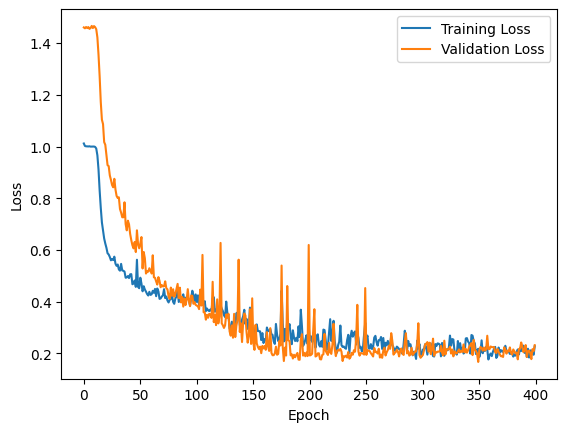

In [49]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load Excel data
data = pd.read_excel("/content/peak2.xlsx")

# Split data into train, validation, and test sets
X = data.iloc[:, :7].to_numpy()  # Features
y = data.iloc[:, 7].to_numpy()  # Labels
y = np.reshape(y, (-1, 1))

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.1,random_state=70)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=70)

y_test_noscale = y_test  # Keep a copy of unscaled y_test for MAPE calculation

# Normalize features using StandardScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler2 = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
y_train = scaler2.fit_transform(y_train)
y_val = scaler2.transform(y_val)
y_test = scaler2.transform(y_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

# Define the MLP model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(7, 1000),
            nn.Sigmoid(),
            nn.Dropout(p=0.1),  # Add dropout layer with dropout rate of 0.1
            nn.Linear(1000, 500),
            nn.Sigmoid(),
            nn.Linear(500, 100),
            nn.Sigmoid(),
            nn.Linear(100, 20),
            nn.Dropout(p=0.1),  # Add dropout layer with dropout rate of 0.1
            nn.Sigmoid(),
            nn.Linear(20, 5),
            nn.Sigmoid(),
            nn.Linear(5, 1),
        )

    def forward(self, x):
        x = self.layers(x)
        return x


# Instantiate the model
model = MLP()
model=model.to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()  # Assuming regression task
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
batch_size = 50  # Set the batch size

# Training loop
train_losses = []
val_losses = []

for epoch in range(400):
    for i in range(0, len(X_train), batch_size):
        batch_X = X_train[i : i + batch_size]
        batch_y = y_train[i : i + batch_size]

        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Calculate and store losses for plotting
    with torch.no_grad():
        train_loss = criterion(model(X_train), y_train)
        val_loss = criterion(model(X_val), y_val)
        train_losses.append(train_loss.item())
        val_losses.append(val_loss.item())

    # Print the loss every 20 epochs
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}, Train Loss: {train_loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

# Evaluate the model on the test set
test_outputs = model(X_test).to(device)
test_loss = criterion(test_outputs, y_test)
print(f"Test Loss: {test_loss.item():.4f}")

# Calculate MAPE
y_test_noscale = torch.tensor(y_test_noscale, dtype=torch.float32)  # Convert back to tensor
mape = torch.mean(torch.abs((test_outputs.to(device) - y_test.to(device)) / y_test_noscale.to(device))) * 100
print(f"MAPE: {mape.item():.4f}%")

# Plot the training and validation loss curves
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [50]:
with torch.no_grad():
    test_outputs = model(X_test)
    # Inverse transform using the scaler
    test_outputs2 = scaler2.inverse_transform(test_outputs.cpu())
    test_outputs2 =torch.from_numpy(test_outputs2)
    # Convert y_test to a NumPy array
    #y_test_np = y_test.numpy()

    # Calculate Mean Absolute Percentage Error (MAPE)
    mape = torch.mean(torch.abs((test_outputs2.to(device) - y_test_noscale.to(device)) / y_test_noscale.to(device))) * 100
    print(f"MAPE: {mape.item():.4f}%")

MAPE: 29.5097%


In [32]:
test_outputs

array([[1.0584295 ],
       [0.39388281],
       [1.43666792],
       [0.31222816],
       [2.61327605],
       [3.58446474],
       [0.6591773 ],
       [0.34491718],
       [3.07563984],
       [0.31089995],
       [1.19840675],
       [3.50671939],
       [3.51603822],
       [1.01462342],
       [2.10499712],
       [1.9001041 ],
       [0.34673274],
       [1.10574864],
       [0.61401158],
       [0.30991183],
       [0.60941106],
       [9.28252138],
       [2.40202123],
       [2.60966288],
       [2.6075268 ],
       [2.0122231 ],
       [2.85206942],
       [1.10050469],
       [0.37187086],
       [1.13164084],
       [2.63304524],
       [0.3115044 ],
       [0.31104694],
       [0.31386012],
       [1.09938593],
       [0.30921601],
       [3.50824894],
       [1.91136101],
       [1.02897995],
       [0.37223777],
       [2.16510195],
       [1.94339641],
       [0.37044429],
       [1.07308798],
       [0.38460521],
       [1.94981333],
       [1.03340246],
       [0.362

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.losses import mean_squared_error

# Load Excel data
data = pd.read_excel("/content/peak2.xlsx")

# Split data into train and test sets using sklearn.model_selection.train_test_split
X = data.iloc[:, :6].to_numpy()  # Features
y = data.iloc[:, 6].to_numpy()  # Labels
y = np.reshape(y, (-1, 1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
y_test_noscale = y_test

# Normalize features using StandardScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler2 = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train = scaler2.fit_transform(y_train)
y_test = scaler2.transform(y_test)

# Define the MLP model
model = Sequential()
model.add(Dense(1000, activation='sigmoid', input_dim=6))
model.add(Dense(500, activation='sigmoid'))
model.add(Dense(100, activation='sigmoid'))
model.add(Dense(20, activation='sigmoid'))
model.add(Dense(5, activation='sigmoid'))
model.add(Dense(1,activation='linear'))

# Define loss function and optimizer
optimizer = Adam(learning_rate=0.001)
loss_fn = mean_squared_error

# Compile the model
model.compile(optimizer=optimizer, loss=loss_fn)

# Training loop (example)
for epoch in range(10000):
    model.fit(X_train, y_train, epochs=1, batch_size=50)

# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")

# Calculate MAPE
y_pred = model.predict(X_test)
mape = np.mean(np.abs((y_pred - y_test) / y_test)) * 100
print(f"MAPE: {mape:.4f}%")

 1/19 [>.............................] - ETA: 0s - loss: 1.0203

KeyboardInterrupt: 

In [ ]:
y_test_noscale

array([[2.67 ],
       [4.08 ],
       [1.62 ],
       [5.7  ],
       [0.5  ],
       [0.61 ],
       [0.176],
       [1.33 ]])